**Import Libraries**

In [1]:
#Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.stattools import pacf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier 
import tensorflow as tf
from datetime import datetime  
from datetime import timedelta

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Data Loading**

In [2]:
#Load Data
url = 'https://raw.githubusercontent.com/dimasananda0501/Time-Series/main/LSTM/JKSE.csv'
data = pd.read_csv(url)
data['Tanggal'] = pd.to_datetime(data['Tanggal'])
data.head()

,Tanggal,Terakhir
0,2019-01-02,6181.1748
1,2019-01-03,6221.0098
2,2019-01-04,6274.5400
3,2019-01-07,6287.2241
4,2019-01-08,6262.8472


In [3]:
data.tail()

,Tanggal,Terakhir
559,2021-04-19,6052.5400
560,2021-04-20,6038.3218
561,2021-04-21,5993.2422
562,2021-04-22,5994.1841
563,2021-04-23,6016.8638


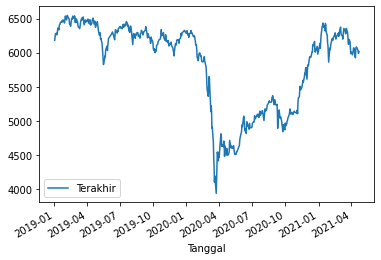

In [4]:
data.plot(x ='Tanggal', y='Terakhir')

**Data Preprocessing**

In [5]:
#Preprocessing
dataset=data['Terakhir'].values
dataset=dataset.astype('float32')
dataset=np.reshape(dataset,(-1,1))
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)

**Data Splitting**

In [6]:
train_size=int(len(dataset)*0.80)
test_size=len(dataset)-train_size
train,test=dataset[0:train_size,:],dataset[train_size:len(dataset),:]
#Create Dataset Function
def create_dataset(dataset,look_back=1):
    X,Y=[],[]
    for i in range (len(dataset)-look_back-1):
        a=dataset[i:(i+look_back),0]
        X.append(a)
        Y.append(dataset[i+look_back,0])
    return np.array(X),np.array(Y)

In [7]:
#Lookback
look_back=1
X_train, Y_train=create_dataset(train,look_back)
X_test, Y_test=create_dataset(test,look_back)
#reshape input to be [samples, time steps, features]
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

**Model Training**

In [8]:
#Model Training
model=Sequential()
model.add(LSTM(5,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1,activation='tanh',kernel_initializer='glorot_uniform',bias_initializer='zero',
                use_bias=True))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error',optimizer='adam')
history=model.fit(X_train,Y_train,epochs=25,batch_size=1,validation_data=(X_test,Y_test),
                  callbacks=[EarlyStopping(monitor='val_loss',patience=10)],verbose=1,shuffle=False)
model.summary()

Epoch 1/25
449/449 [==============================] - 3s 3ms/step - loss: 0.1238 - val_loss: 0.0583
Epoch 2/25
449/449 [==============================] - 1s 2ms/step - loss: 0.0720 - val_loss: 0.0476
Epoch 3/25
449/449 [==============================] - 1s 2ms/step - loss: 0.0596 - val_loss: 0.0487
Epoch 4/25
449/449 [==============================] - 1s 2ms/step - loss: 0.0541 - val_loss: 0.0484
Epoch 5/25
449/449 [==============================] - 1s 2ms/step - loss: 0.0472 - val_loss: 0.0396
Epoch 6/25
449/449 [==============================] - 1s 2ms/step - loss: 0.0348 - val_loss: 0.0189
Epoch 7/25
449/449 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0062
Epoch 8/25
449/449 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0024
Epoch 9/25
449/449 [==============================] - 1s 2ms/step - loss: 0.0084 - val_loss: 0.0017
Epoch 10/25
449/449 [==============================] - 1s 2ms/step - loss: 0.0080 - val_loss: 0.0016

**Predictions**

In [9]:
#Predict
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
#invert prediction
train_predict=scaler.inverse_transform(train_predict)
Y_train=scaler.inverse_transform([Y_train])
test_predict=scaler.inverse_transform(test_predict)
Y_test=scaler.inverse_transform([Y_test])

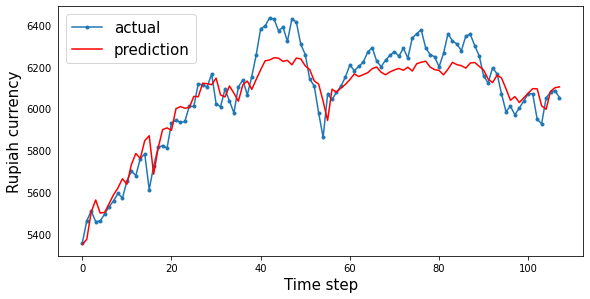

In [10]:
#Plot Prediction
aa=[x for x in range(108)]
plt.figure(figsize=(8,4))
plt.plot(aa,Y_test[0][:108],marker='.',label="actual")
plt.plot(aa,test_predict[:,0][:108],'r',label="prediction")
plt.tick_params(left=False,labelleft=True) #remove ticks
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Rupiah currency',size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

**Model Evaluation**

In [11]:
print('Train Mean Absolute Error:',
      mean_absolute_error(Y_train[0],train_predict[:,0]))
print('Train Root Mean Squared Error:',
      np.sqrt(mean_squared_error(Y_train[0],train_predict[:,0])))
print('Test Mean Absolute Error:',
      mean_absolute_error(Y_test[0],test_predict[:,0]))
print('Test Root Mean Squared Error:',
      np.sqrt(mean_squared_error(Y_test[0],test_predict[:,0])))

Train Mean Absolute Error: 105.03786705723441
Train Root Mean Squared Error: 136.77786061097495
Test Mean Absolute Error: 72.48871406839037
Test Root Mean Squared Error: 90.58177193972057


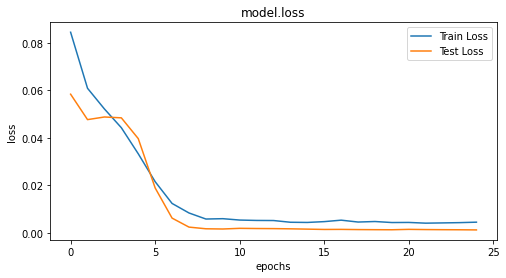

In [12]:
#Plot loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('model.loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [13]:
#MAPE
def mean_absolute_percentage_error (Y_test,test_predict) :
    Y_test, test_predict=np.array(Y_test),np.array(test_predict)
    return np.mean(np.abs((Y_test-test_predict)/Y_test))*100
mean_absolute_percentage_error (Y_test,test_predict)

4.172389997607462

**Predict The Next 7 Days**

In [14]:
X_FUTURE = 7
predictions = np.array([])
last = X_test[-1]
for i in range(X_FUTURE):
  curr_prediction = model.predict(np.array([last]))
  last = np.concatenate([last[1:], curr_prediction])
  predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = scaler.inverse_transform([predictions])[0]
print(predictions)

[6045.2578741  6079.49291704 6100.14838945 6111.91915533 6118.40119799
 6121.90165349 6123.77222447]


In [15]:
# Create a Predictions Dataframe 
new_data = pd.DataFrame({'Prediksi':predictions})
start = data['Tanggal'].iloc[-1]
start_date = start + timedelta(days=1)
new_data['Tanggal'] = pd.date_range(start=start_date, periods=len(new_data), freq='D')
new_data = new_data.reindex(columns=['Tanggal', 'Prediksi'])
new_data

,Tanggal,Prediksi
0,2021-04-24,6045.257874
1,2021-04-25,6079.492917
2,2021-04-26,6100.148389
3,2021-04-27,6111.919155
4,2021-04-28,6118.401198
5,2021-04-29,6121.901653
6,2021-04-30,6123.772224


In [ ]:
first = new_data[0:1]
first.rename(columns = {'Prediksi':'Terakhir'}, inplace = True)
df = pd.concat([data, first], ignore_index=True)

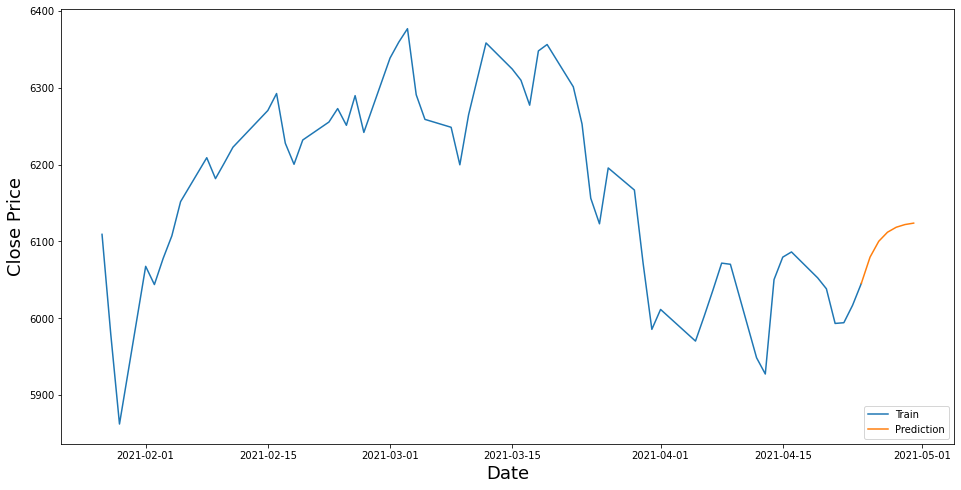

In [17]:
#Visualize the data
x1 = df['Tanggal'].iloc[-61:]
y1 = df['Terakhir'].iloc[-61:]
x2 = new_data['Tanggal']
y2 = new_data['Prediksi']
plt.figure(figsize=(16,8))
plt.title('')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(x1, y1, label = "Train")
plt.plot(x2, y2, label = "Prediction")
plt.legend(loc='lower right')
plt.show()